In [1]:
import os
import pandas as pd
import numpy as np
import re

from plotnine import *
from plotnine import options

In [2]:
MAIN_KEY_SIZE = 'size'
MAIN_KEY_APPROACH = 'approach'

phase_order = [
    'RADIANCE',
    'REFLECTANCE',
    'ALBEDO',
    'NDVI',
    'PAI',
    'LAI',
    'ENB_EMISSIVITY',
    'EO_EMISSIVITY',
    'EA_EMISSIVITY',
    'SURFACE_TEMPERATURE',
    'SHORT_WAVE_RADIATION',
    'LARGE_WAVE_RADIATION_SURFACE',
    'LARGE_WAVE_RADIATION_ATMOSPHERE',
    'NET_RADIATION',
    'SOIL_HEAT_FLUX',
    'PIXEL_FILTER',
    'D0',
    'ZOM',
    'USTAR',
    'KB1',
    'RAH_INI',
    'RAH_CYCLE',
    'SENSIBLE_HEAT_FLUX',
    'LATENT_HEAT_FLUX',
    'NET_RADIATION_24H',
    'EVAPOTRANSPIRATION_24H',
    'P0_READ_INPUT',
    'P1_INITIAL_PROD',
    'P2_PIXEL_SEL',
    'P3_RAH',
    'P4_FINAL_PROD',
    'P5_COPY_HOST',
    'P6_SAVE_PRODS',
    'P_TOTAL',
]

## Aux functions

In [3]:
def rename_phases(df, column_name='PHASE'):
    phase_mapping = {
        'ENB_EMISSIVITY': 'ENB',
        'EO_EMISSIVITY': 'EO',
        'EA_EMISSIVITY': 'EA',
        'SURFACE_TEMPERATURE': 'ST',
        'SHORT_WAVE_RADIATION': 'SR',
        'LARGE_WAVE_RADIATION_SURFACE': 'LR_SHORT',
        'LARGE_WAVE_RADIATION_ATMOSPHERE': 'LR_LONG',
        'NET_RADIATION' : 'Rn',
        'SOIL_HEAT_FLUX': 'G',
        'SENSIBLE_HEAT_FLUX': 'H',
        'LATENT_HEAT_FLUX': 'LE',
        'NET_RADIATION_24H': 'Rn_24H',
        'EVAPOTRANSPIRATION_24H': 'EVAPO_24H'
    }
    
    # Cria uma cópia do DataFrame para não modificar o original
    df_renamed = df.copy()
    
    # Aplica o mapeamento
    df_renamed[column_name] = df_renamed[column_name].replace(phase_mapping)
    
    return df_renamed

In [4]:
def get_mode(series):
    """Função para obter a moda de uma série."""
    mode_values = series.mode()
    # Retorna o primeiro valor da moda se houver múltiplos valores
    return mode_values.iloc[0] if not mode_values.empty else None

def combine_dfs(base_dir):
    dataframes = []

    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        if 'time.csv' in files:
            # Read the CSV file and append the DataFrame to the list
            df = pd.read_csv(os.path.join(root, 'time.csv'))
            # df = df[df['PHASE'] != 'P6_SAVE_PRODS']
            # df.to_csv(os.path.join(root, 'time.csv'), index=False)
            dataframes.append(df[['PHASE', 'TIMESTAMP']])

    # Concatenate all DataFrames in the list into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
    else:
        combined_df = pd.DataFrame()  # Empty DataFrame if no files found

    return combined_df

In [5]:
def extract_size(key):
    match = re.search(r'(\d+)$', key)
    return int(match.group(1)) if match else None

def consolidate_dataframes(dic_mean_times, main_key=MAIN_KEY_SIZE):
    consolidated_data = []
    
    for key, df in dic_mean_times.items():
        # Extrai o tamanho (size) da chave
        size = 7295 # extract_size(key)
        name = key.split('-')[0]

        df['experiment'] = key
        if main_key == MAIN_KEY_SIZE:
            df['size'] = size
            df = df[['size', 'PHASE', 'TIMESTAMP', 'experiment']]
        elif main_key == MAIN_KEY_APPROACH:
            df['approach'] = name
            df = df[['approach', 'PHASE', 'TIMESTAMP', 'experiment']]
                
        # Adiciona o DataFrame à lista consolidada
        consolidated_data.append(df)
    
    # Concatena todos os DataFrames da lista em um único DataFrame
    combined_df = pd.concat(consolidated_data, ignore_index=True)
    
    # Usa pivot para reorganizar o DataFrame de acordo com o formato desejado
    pivot_df = combined_df.pivot_table(
        index=[main_key, 'PHASE'],
        columns='experiment',
        values='TIMESTAMP',
        aggfunc='mean'
    ).reset_index()
    
    # Renomeia as colunas para remover o prefixo criado pelo pivot
    pivot_df.columns.name = None
    
    return pivot_df

# Summarize

In [6]:
directories = {
    "./output": ["serial-0", "serial-1", "kernels-0", "kernels-1", "cutensor-0", "cutensor-1", "hybrid-0", "hybrid-1"]
}

dic_combined = dict()
for dir, subdirs in directories.items():
    for subdir in subdirs:
        subdir_path = os.path.join(dir, subdir)
        subdir_rename = subdir.replace('0', 'steep')
        subdir_rename = subdir_rename.replace('1', 'sebal')
        dic_combined[subdir_rename] = combine_dfs(subdir_path)

dic_summarized = dict()
for key in dic_combined.keys():
    combined_df = dic_combined[key]
    combined_df.groupby('PHASE')
    summarized = combined_df.groupby('PHASE')['TIMESTAMP'].mean().reset_index()
    # summarized = combined_df.groupby('PHASE')['TIMESTAMP'].apply(get_mode).reset_index()

    summarized['PHASE'] = pd.Categorical(
        summarized['PHASE'], 
        categories=phase_order, 
        ordered=True
    )
    
    summarized = summarized.sort_values('PHASE').reset_index(drop=True)

    dic_summarized[key] = summarized


In [7]:
dic_summarized["kernels-steep"]

,PHASE,TIMESTAMP
0,RADIANCE,0.532367
1,REFLECTANCE,3.501724
2,ALBEDO,3.870729
3,NDVI,0.671155
4,PAI,0.771817
5,LAI,6.338878
6,ENB_EMISSIVITY,0.577425
7,EO_EMISSIVITY,0.578039
8,EA_EMISSIVITY,15.768870
9,SURFACE_TEMPERATURE,0.686728


# Approaches comparation

In [8]:
# Executa a função para consolidar os DataFrames
final_df = consolidate_dataframes(dic_summarized, MAIN_KEY_SIZE)
final_df = final_df[final_df['size'] == 7295].dropna(axis=1, how='all')
# final_df = final_df[final_df['size'] == 3251].dropna(axis=1, how='all')


/tmp/ipykernel_3220106/951167118.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [9]:
# Exibe o DataFrame consolidado
final_df

,size,PHASE,cutensor-sebal,cutensor-steep,hybrid-sebal,hybrid-steep,kernels-sebal,kernels-steep,serial-sebal,serial-steep
0,7295,RADIANCE,3.237984,3.220019,0.532789,0.535059,0.537639,0.532367,101.514440,101.214680
1,7295,REFLECTANCE,11.003569,11.062225,3.490237,3.503382,3.519227,3.501724,1160.570321,1159.787211
2,7295,ALBEDO,5.846509,5.861802,3.848015,3.876899,3.888340,3.870729,248.421763,248.946784
3,7295,NDVI,2.575602,2.581072,0.677007,0.676857,0.671238,0.671155,144.999771,145.125410
4,7295,PAI,NaN,1.878951,NaN,0.779170,NaN,0.771817,NaN,163.613723
5,7295,LAI,5.369457,5.380833,7.575935,7.569868,6.370051,6.338878,396.692832,396.807121
6,7295,ENB_EMISSIVITY,1.162236,1.169697,0.581546,0.581132,0.581420,0.577425,107.948428,107.925693
7,7295,EO_EMISSIVITY,1.162522,1.167732,0.580030,0.575061,0.577296,0.578039,107.587955,107.546874
8,7295,EA_EMISSIVITY,2.123797,2.127272,2.126796,2.126835,15.843002,15.768870,817.408452,817.294557
9,7295,SURFACE_TEMPERATURE,3.057318,3.064479,0.691611,0.691185,0.688751,0.686728,204.482304,204.540937


In [10]:
## export final_df to xls, salve os numeros com virgula
final_df.to_excel("final_df.xlsx")

# Individual prods

In [11]:
for key, df in dic_combined.items():
    df['SIZE'] = 7295
    df['LANG'] = key.split('-')[0]
    df['METHOD'] = key.split('-')[1] 
    
combined_dff = pd.concat(dic_combined.values(), ignore_index=True)
combined_dff = combined_dff[~combined_dff['PHASE'].str.match(r'^P.\_') & (combined_dff['PHASE'] != 'P_TOTAL')]
combined_dff = rename_phases(combined_dff)

#select by METHOD 
sebal = combined_dff[combined_dff['METHOD'] == 'sebal'].dropna()
steep = combined_dff[combined_dff['METHOD'] == 'steep'].dropna()

sebal['TIME_LOG'] = np.log(sebal['TIMESTAMP'])
steep['TIME_LOG'] = np.log(sebal['TIMESTAMP'])

#select by LANG
cpp_sebal = sebal[sebal['LANG'] == 'cpp']
kernels_sebal = sebal[sebal['LANG'] == 'kernels']
hybrid_sebal = sebal[sebal['LANG'] == 'hybrid']
cutensor_sebal = sebal[sebal['LANG'] == 'cutensor']

cpp_steep = steep[steep['LANG'] == 'cpp']
kernels_steep = steep[steep['LANG'] == 'kernels']
hybrid_steep = steep[steep['LANG'] == 'hybrid']
cutensor_steep = steep[steep['LANG'] == 'cutensor']

In [12]:
combined_dff

,PHASE,TIMESTAMP,SIZE,LANG,METHOD
1,RADIANCE,100.569817,7295,serial,steep
2,REFLECTANCE,1155.469604,7295,serial,steep
3,ALBEDO,252.072906,7295,serial,steep
4,NDVI,145.337570,7295,serial,steep
5,LAI,398.653717,7295,serial,steep
...,...,...,...,...,...
28703,RAH_CYCLE,137.764923,7295,hybrid,sebal
28704,H,0.811776,7295,hybrid,sebal
28706,LE,0.879360,7295,hybrid,sebal
28707,Rn_24H,0.503808,7295,hybrid,sebal


# Phases prods

In [13]:
for key, df in dic_combined.items():
    df['SIZE'] = 7295
    df['LANG'] = key.split('-')[0]
    df['METHOD'] = key.split('-')[1] 
    
p_combined_dff = pd.concat(dic_combined.values(), ignore_index=True)
p_combined_dff = p_combined_dff[p_combined_dff['PHASE'].str.match(r'^P.\_')]
p_combined_dff = rename_phases(p_combined_dff)

#select by METHOD 
sebal = p_combined_dff[p_combined_dff['METHOD'] == 'sebal'].dropna()
steep = p_combined_dff[p_combined_dff['METHOD'] == 'steep'].dropna()

sebal['TIME_LOG'] = np.log(sebal['TIMESTAMP'])
steep['TIME_LOG'] = np.log(sebal['TIMESTAMP'])

#select by LANG
cpp_sebal = sebal[sebal['LANG'] == 'cpp']
kernels_sebal = sebal[sebal['LANG'] == 'kernels']
hybrid_sebal = sebal[sebal['LANG'] == 'hybrid']
cutensor_sebal = sebal[sebal['LANG'] == 'cutensor']

cpp_steep = steep[steep['LANG'] == 'cpp']
kernels_steep = steep[steep['LANG'] == 'kernels']
hybrid_steep = steep[steep['LANG'] == 'hybrid']
cutensor_steep = steep[steep['LANG'] == 'cutensor']

# Speedup

In [14]:
serial = p_combined_dff[p_combined_dff['LANG'] == 'serial'].groupby(['PHASE', 'METHOD'])['TIMESTAMP'].max()
cutensor = p_combined_dff[p_combined_dff['LANG'] == 'cutensor'].groupby(['PHASE', 'METHOD'])['TIMESTAMP'].max()
kernels = p_combined_dff[p_combined_dff['LANG'] == 'kernels'].groupby(['PHASE', 'METHOD'])['TIMESTAMP'].max()
hybrid = p_combined_dff[p_combined_dff['LANG'] == 'hybrid'].groupby(['PHASE', 'METHOD'])['TIMESTAMP'].max()

# create a df speedup with cutensor + kernels + hybrid
gpu_speedup = pd.DataFrame({
    'serial': serial,
    'cutensor': cutensor,
    'kernels': kernels,
    'hybrid': hybrid
})

gpu_speedup['cutensor'] = round(gpu_speedup['serial'] / gpu_speedup['cutensor'], 2)
gpu_speedup['kernels'] = round(gpu_speedup['serial'] / gpu_speedup['kernels'], 2)
gpu_speedup['hybrid'] = round(gpu_speedup['serial'] / gpu_speedup['hybrid'], 2)
# gpu_speedup['serial'] = round(gpu_speedup['serial'] / gpu_speedup['serial'], 2)

# Resetando o index para ter PHASE e METHOD como colunas
gpu_speedup_reset = gpu_speedup.reset_index()

# Convertendo para formato long
gpu_speedup_long = pd.melt(
    gpu_speedup_reset, 
    id_vars=['PHASE', 'METHOD'], 
    value_vars=['cutensor', 'kernels', 'hybrid'],
    var_name='LANG',
    value_name='SPEEDUP'
)
gpu_speedup_long

,PHASE,METHOD,LANG,SPEEDUP
0,P0_READ_INPUT,sebal,cutensor,0.84
1,P0_READ_INPUT,steep,cutensor,0.84
2,P1_INITIAL_PROD,sebal,cutensor,93.68
3,P1_INITIAL_PROD,steep,cutensor,93.07
4,P2_PIXEL_SEL,sebal,cutensor,98.09
5,P2_PIXEL_SEL,steep,cutensor,826.55
6,P3_RAH,sebal,cutensor,41.45
7,P3_RAH,steep,cutensor,47.46
8,P4_FINAL_PROD,sebal,cutensor,147.26
9,P4_FINAL_PROD,steep,cutensor,106.73


# Plots

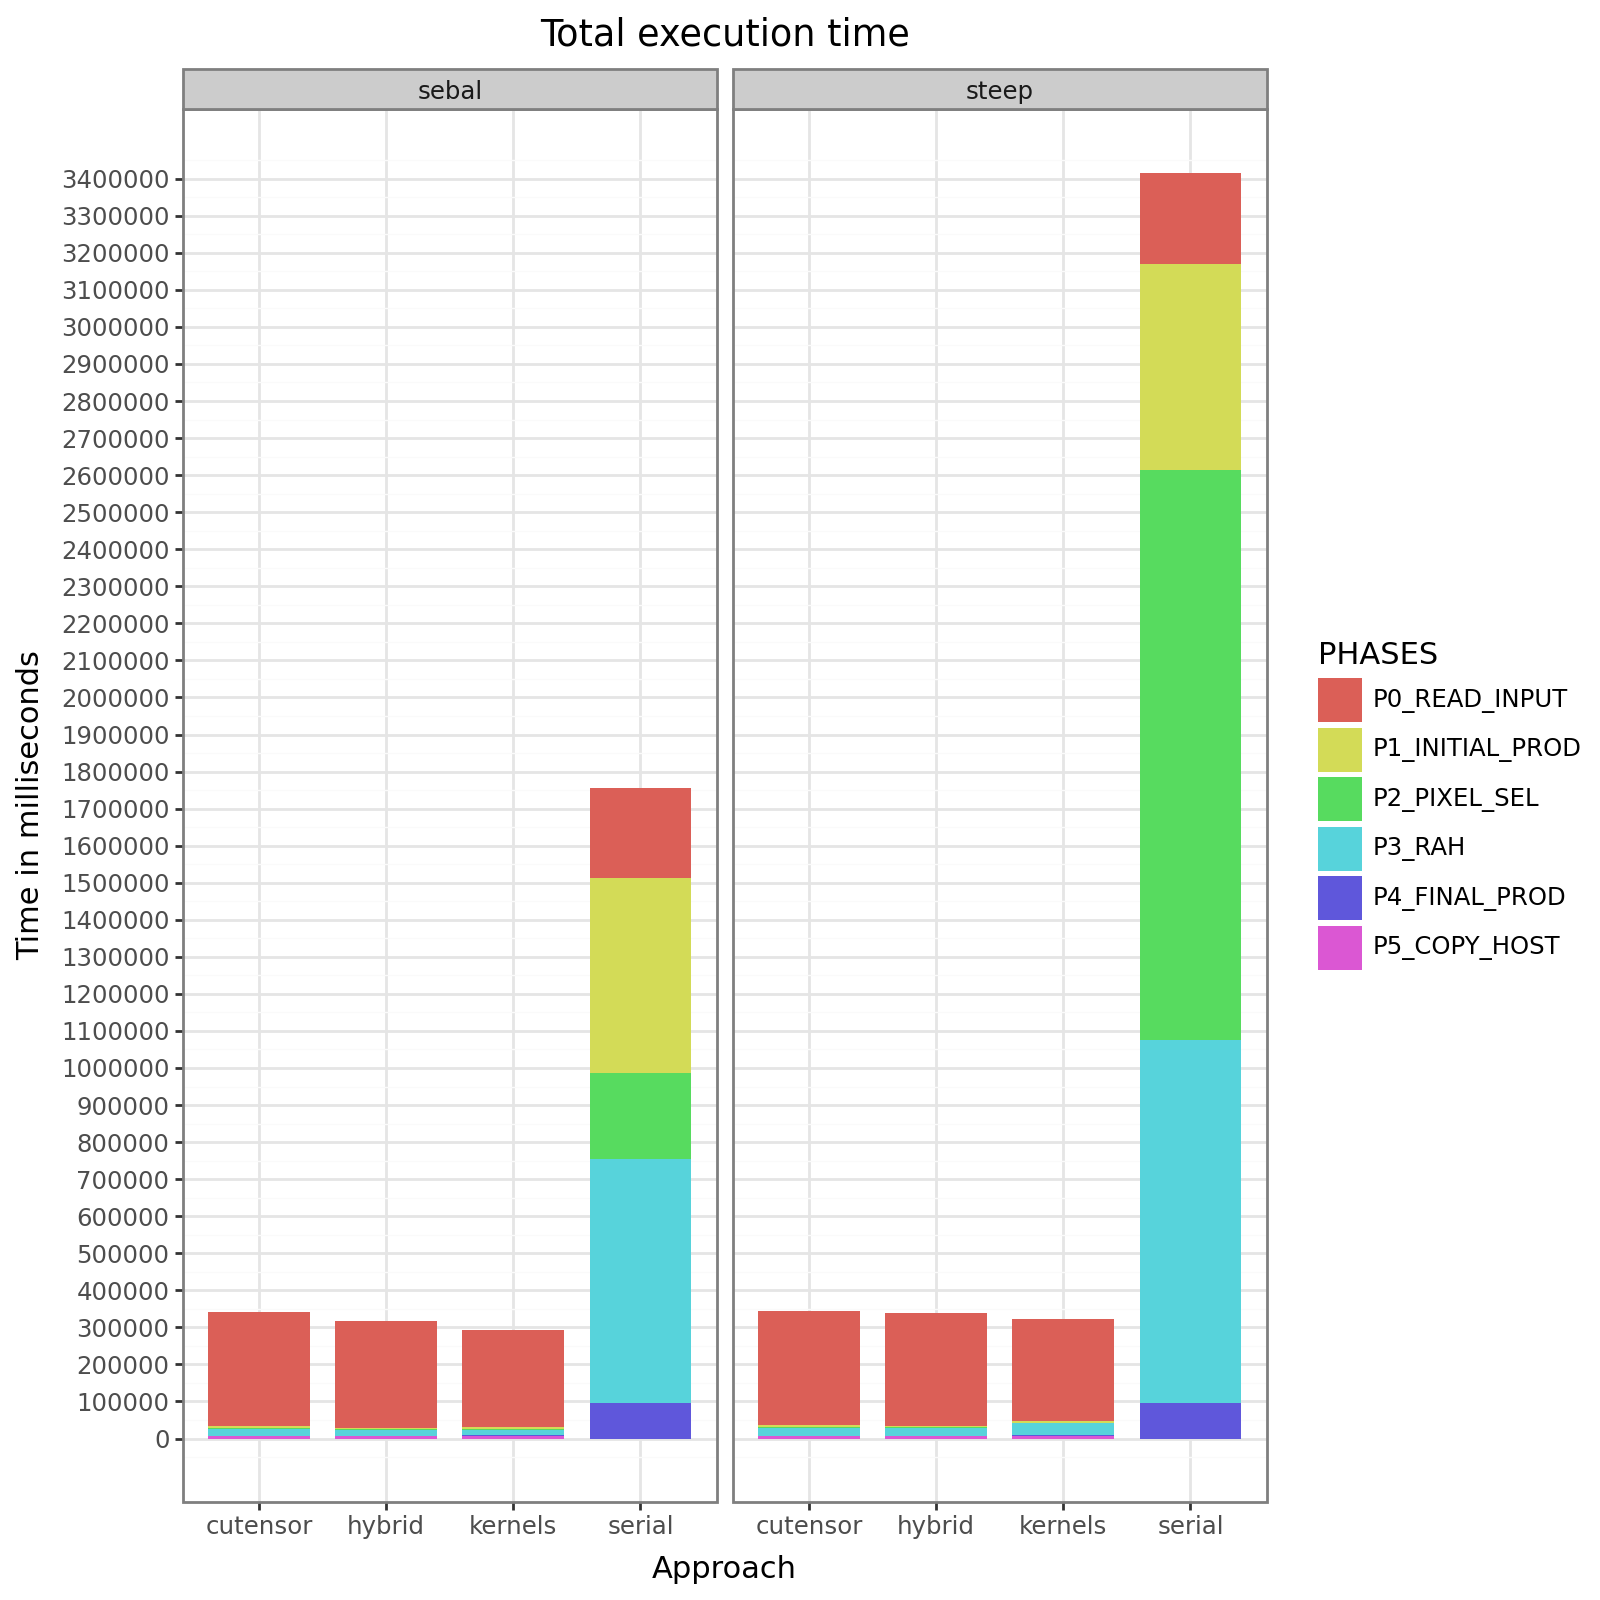

In [15]:
# ========== Total execution time

options.figure_size = (8, 8)
(ggplot(p_combined_dff, aes(x='LANG', y='TIMESTAMP', fill='PHASE'))
        + geom_bar(stat='identity', position='stack', width=0.8)
        + facet_grid(' ~ METHOD')
        + labs(title=f"Total execution time", y='Time in milliseconds', x='Approach')
        + guides(fill=guide_legend(title="PHASES"))
        + scale_y_continuous(breaks=range(0, 3500000, 100000))
        # + coord_flip()
        + theme_bw())

/home/clsmfm/workspace/landsat/landsat-results/venv/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 6 rows containing missing values.
/home/clsmfm/workspace/landsat/landsat-results/venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 6 rows containing missing values.


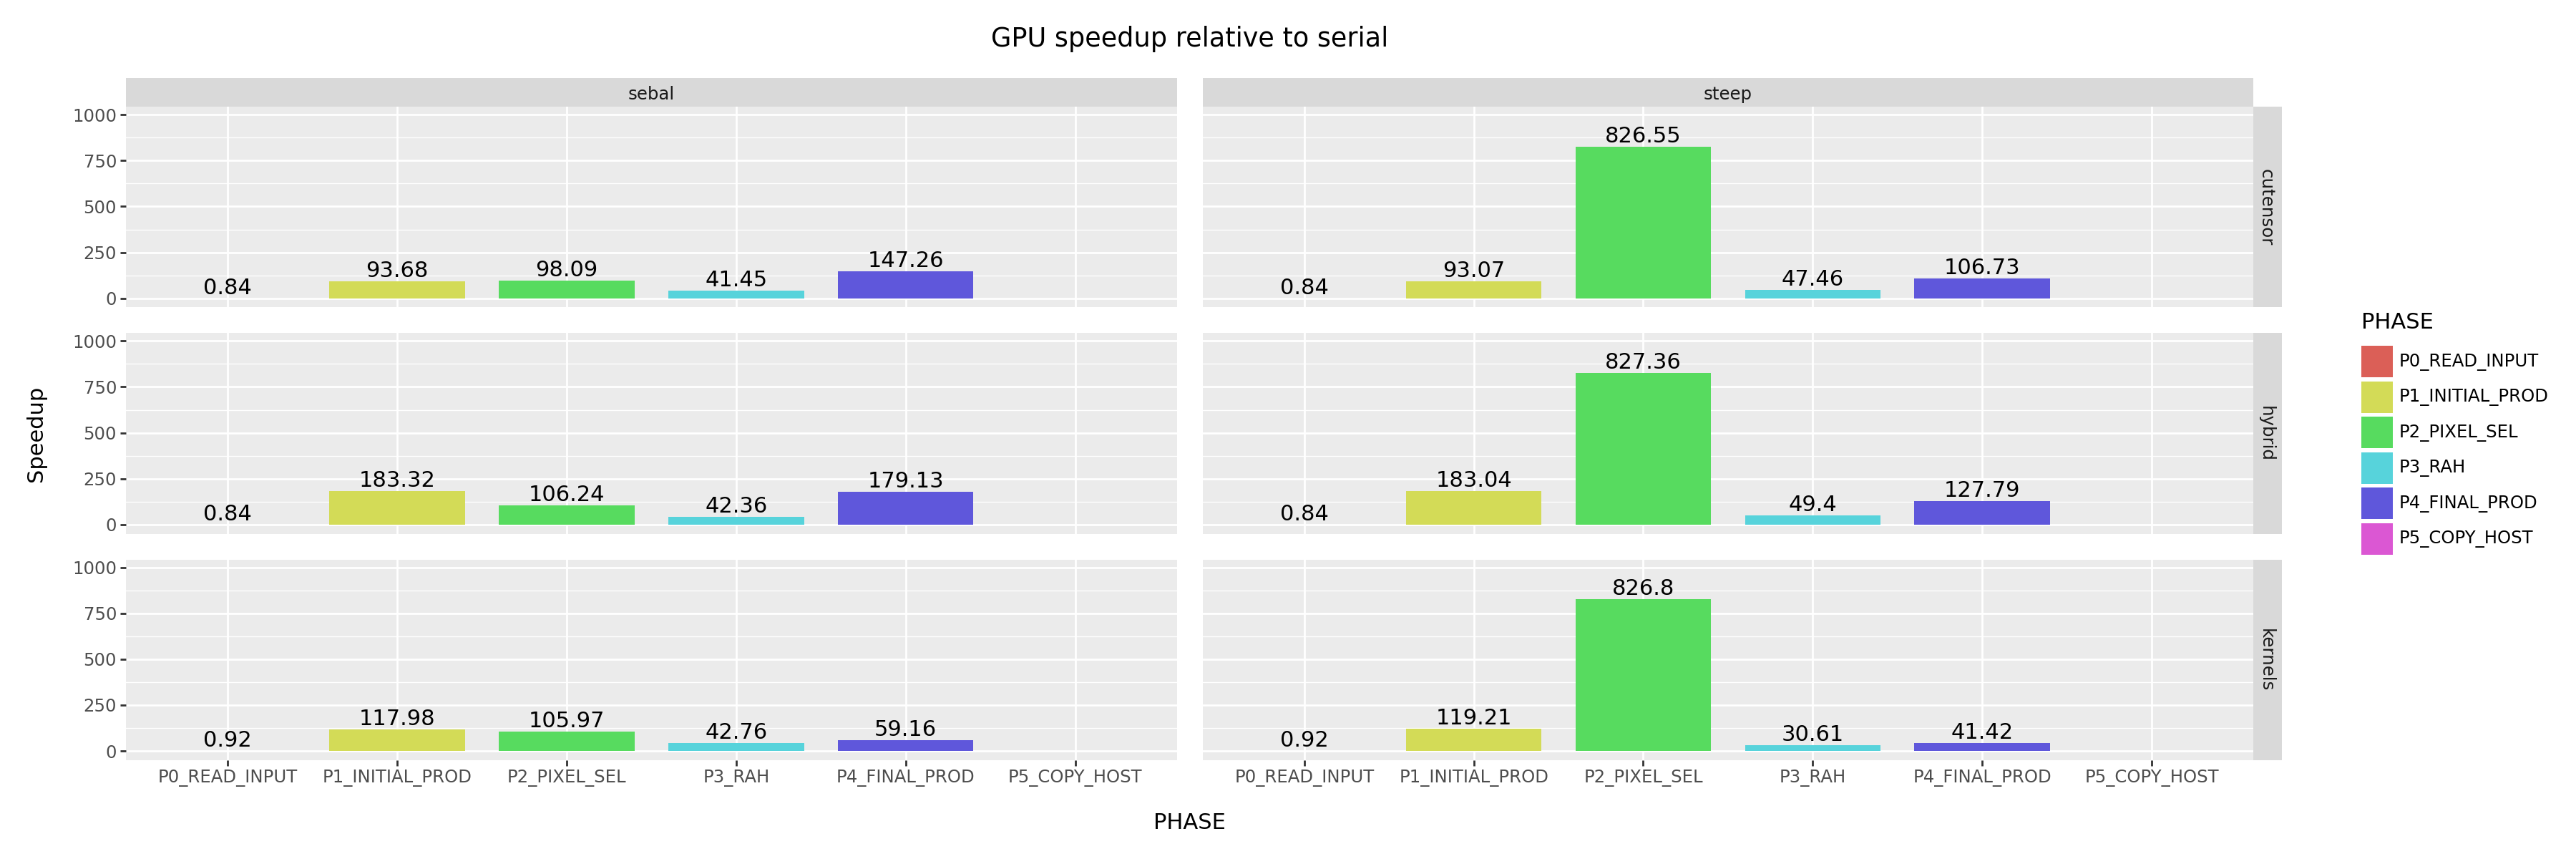

In [16]:
# ========== GPU speedup relative to serial
options.figure_size = (18, 6)
(ggplot(gpu_speedup_long, aes(x='PHASE', y='SPEEDUP', fill='PHASE'))
        + geom_bar(stat='identity', width=0.8)
        + geom_text(aes(label='SPEEDUP'), va='bottom')
        + facet_grid('LANG ~ METHOD')
        + scale_y_continuous(limits=[0, max(gpu_speedup_long['SPEEDUP']) * 1.2])  # aumenta em 20%
        + labs(title=f"GPU speedup relative to serial", y='Speedup', x='PHASE'))

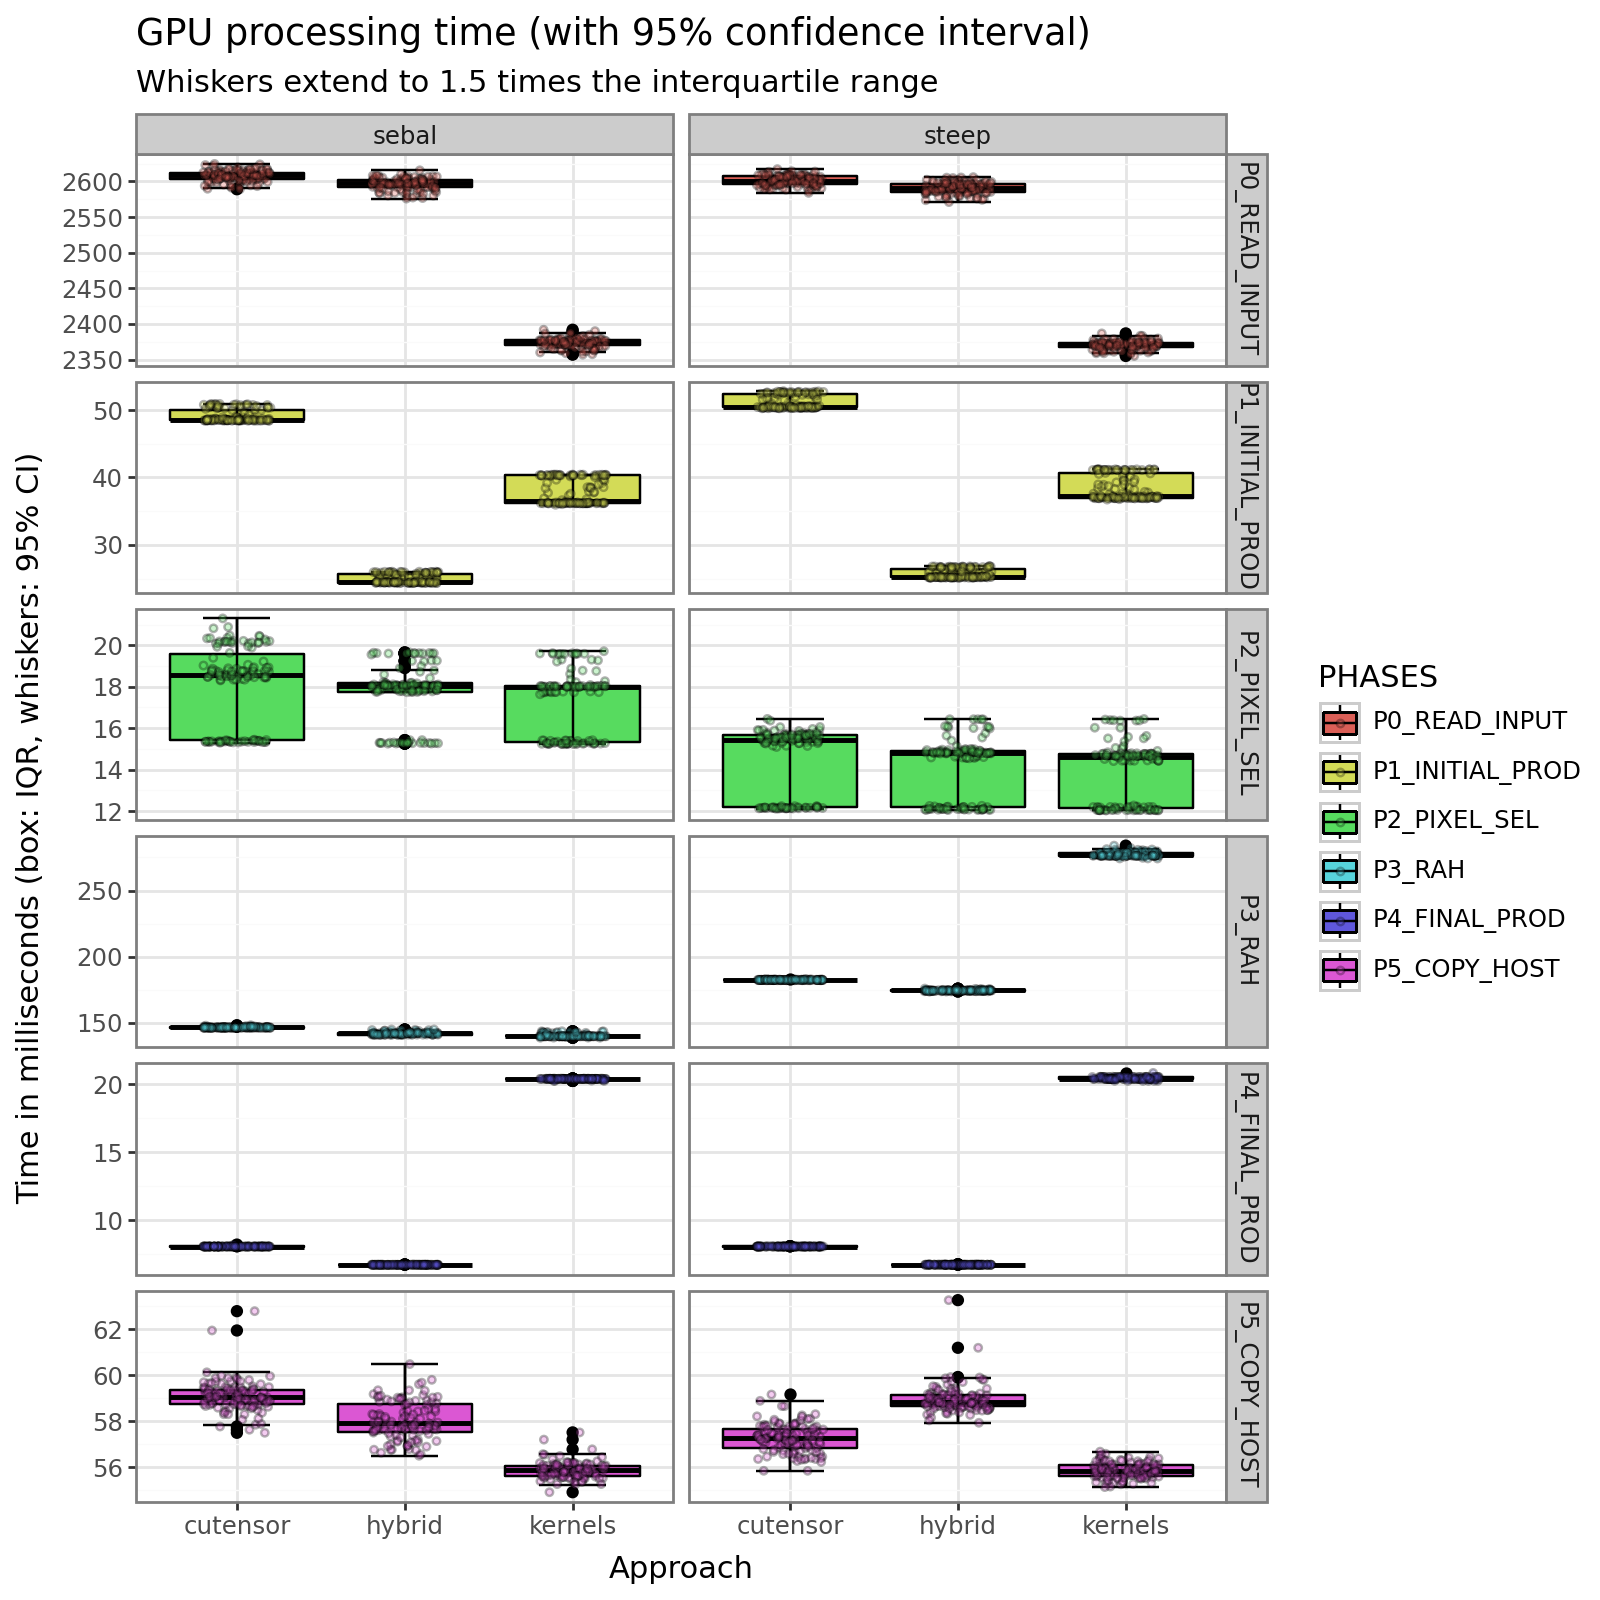

In [32]:
# ========== GPU processing time 
df = p_combined_dff[p_combined_dff['LANG'] != 'serial']

options.figure_size = (8, 8)
(ggplot(df, aes(x='LANG', y='TIMESTAMP', fill='PHASE'))
        + geom_boxplot(width=0.8, color='black', coef=1.5)
        + stat_boxplot(geom='errorbar', width=0.4)
        + geom_point(position=position_jitter(width=0.2), alpha=0.3, size=1)
        + facet_grid('PHASE ~ METHOD', scales='free')
        + labs(
            title=f"GPU processing time (with 95% confidence interval)",
            subtitle="Whiskers extend to 1.5 times the interquartile range",
            y='Time in milliseconds (box: IQR, whiskers: 95% CI)',
            x='Approach'
        )
        + guides(fill=guide_legend(title="PHASES"))
        + theme_bw())

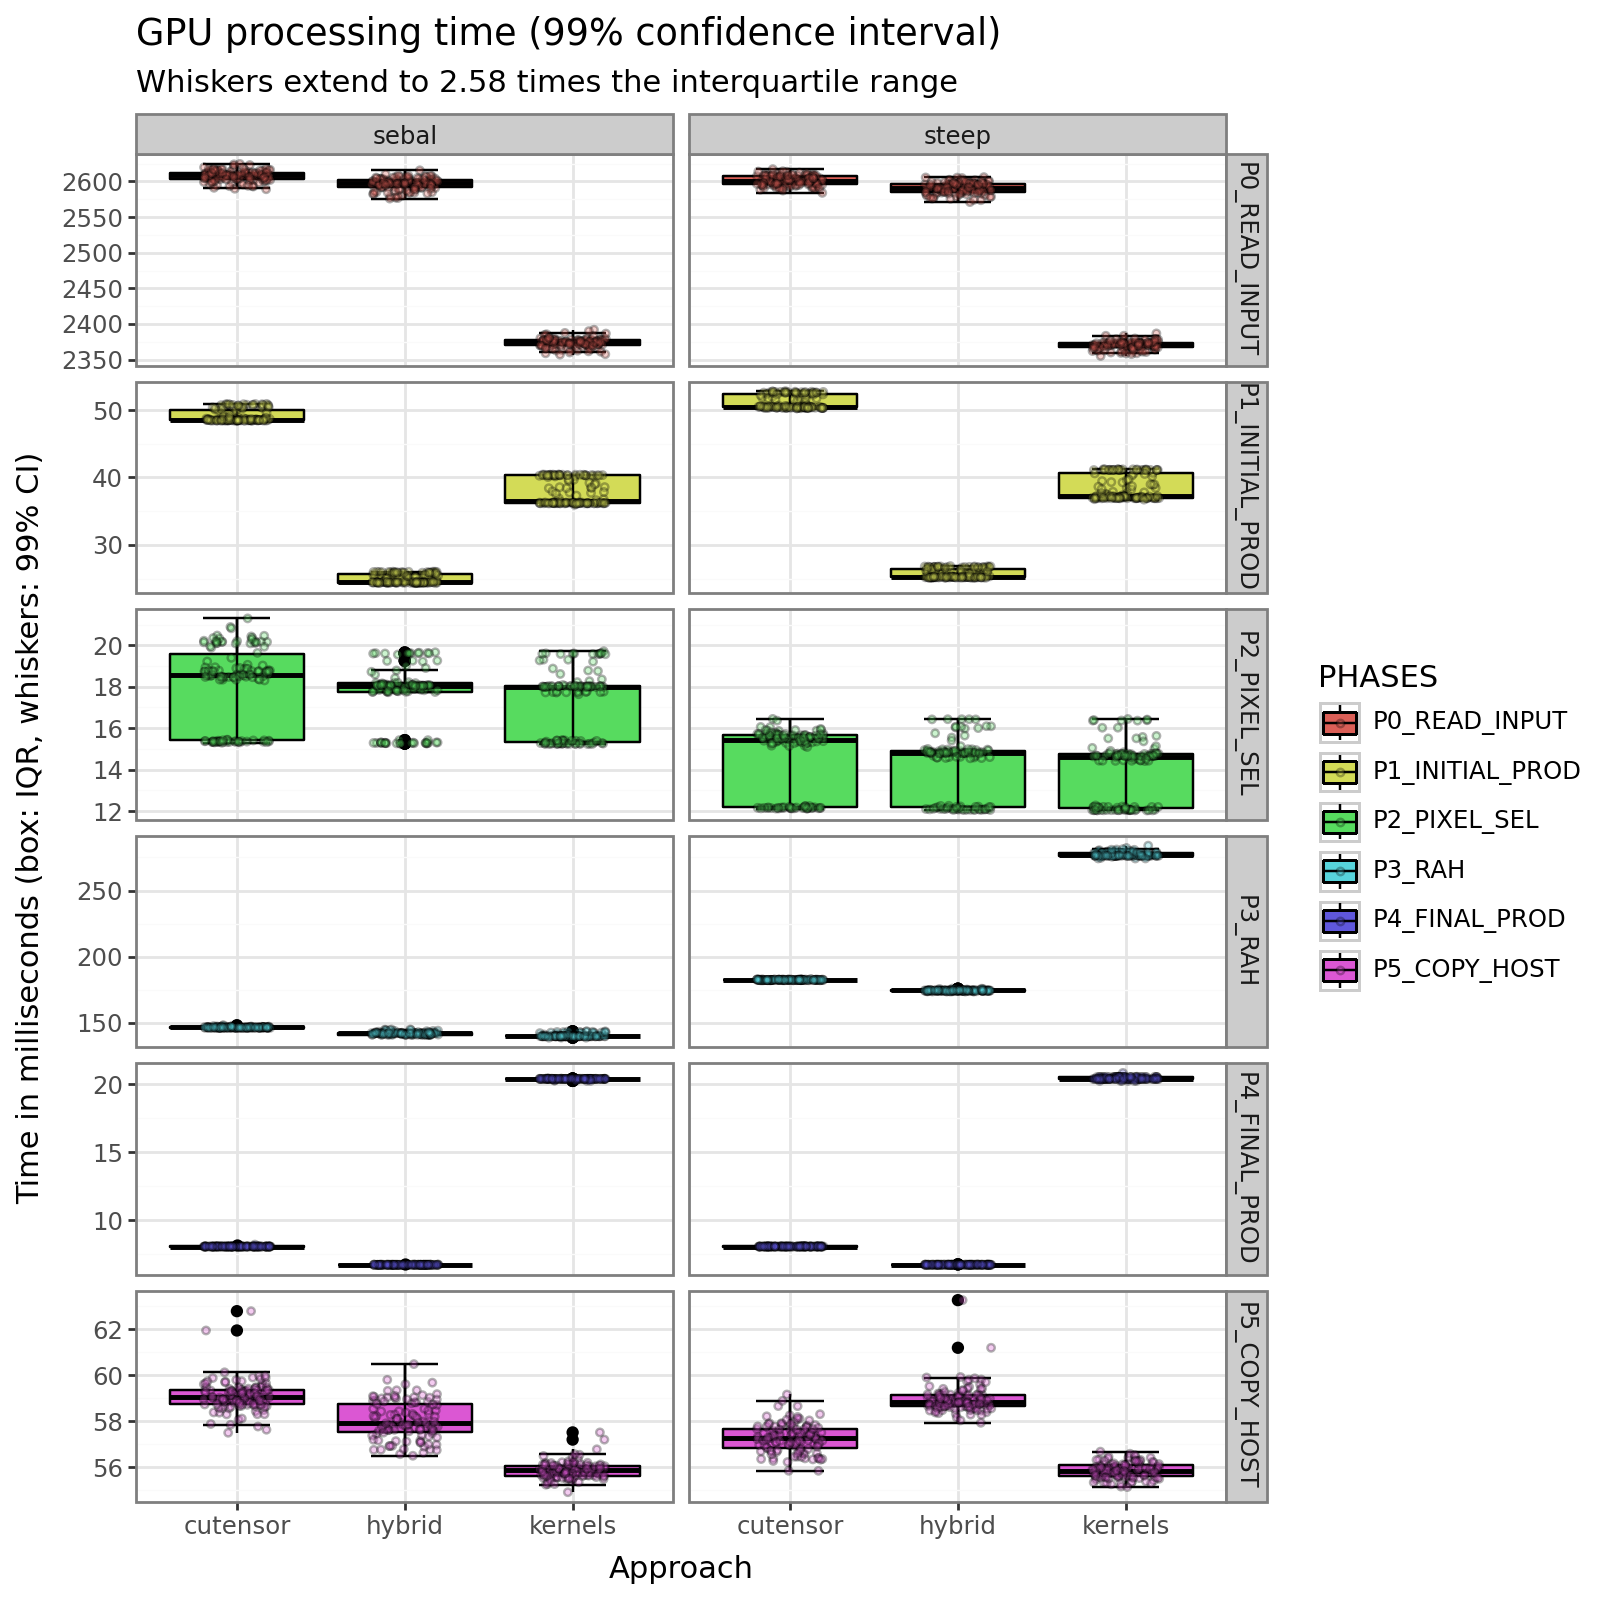

In [33]:
df = p_combined_dff[p_combined_dff['LANG'] != 'serial']

(ggplot(df, aes(x='LANG', y='TIMESTAMP', fill='PHASE'))
        + geom_boxplot(width=0.8, color='black', coef=2.58)
        + stat_boxplot(geom='errorbar', width=0.4)
        + geom_point(position=position_jitter(width=0.2), alpha=0.3, size=1)
        + facet_grid('PHASE ~ METHOD', scales='free')
        + labs(
            title=f"GPU processing time (99% confidence interval)",
            subtitle="Whiskers extend to 2.58 times the interquartile range",
            y='Time in milliseconds (box: IQR, whiskers: 99% CI)',
            x='Approach'
        )
        + guides(fill=guide_legend(title="PHASES"))
        + theme_bw())

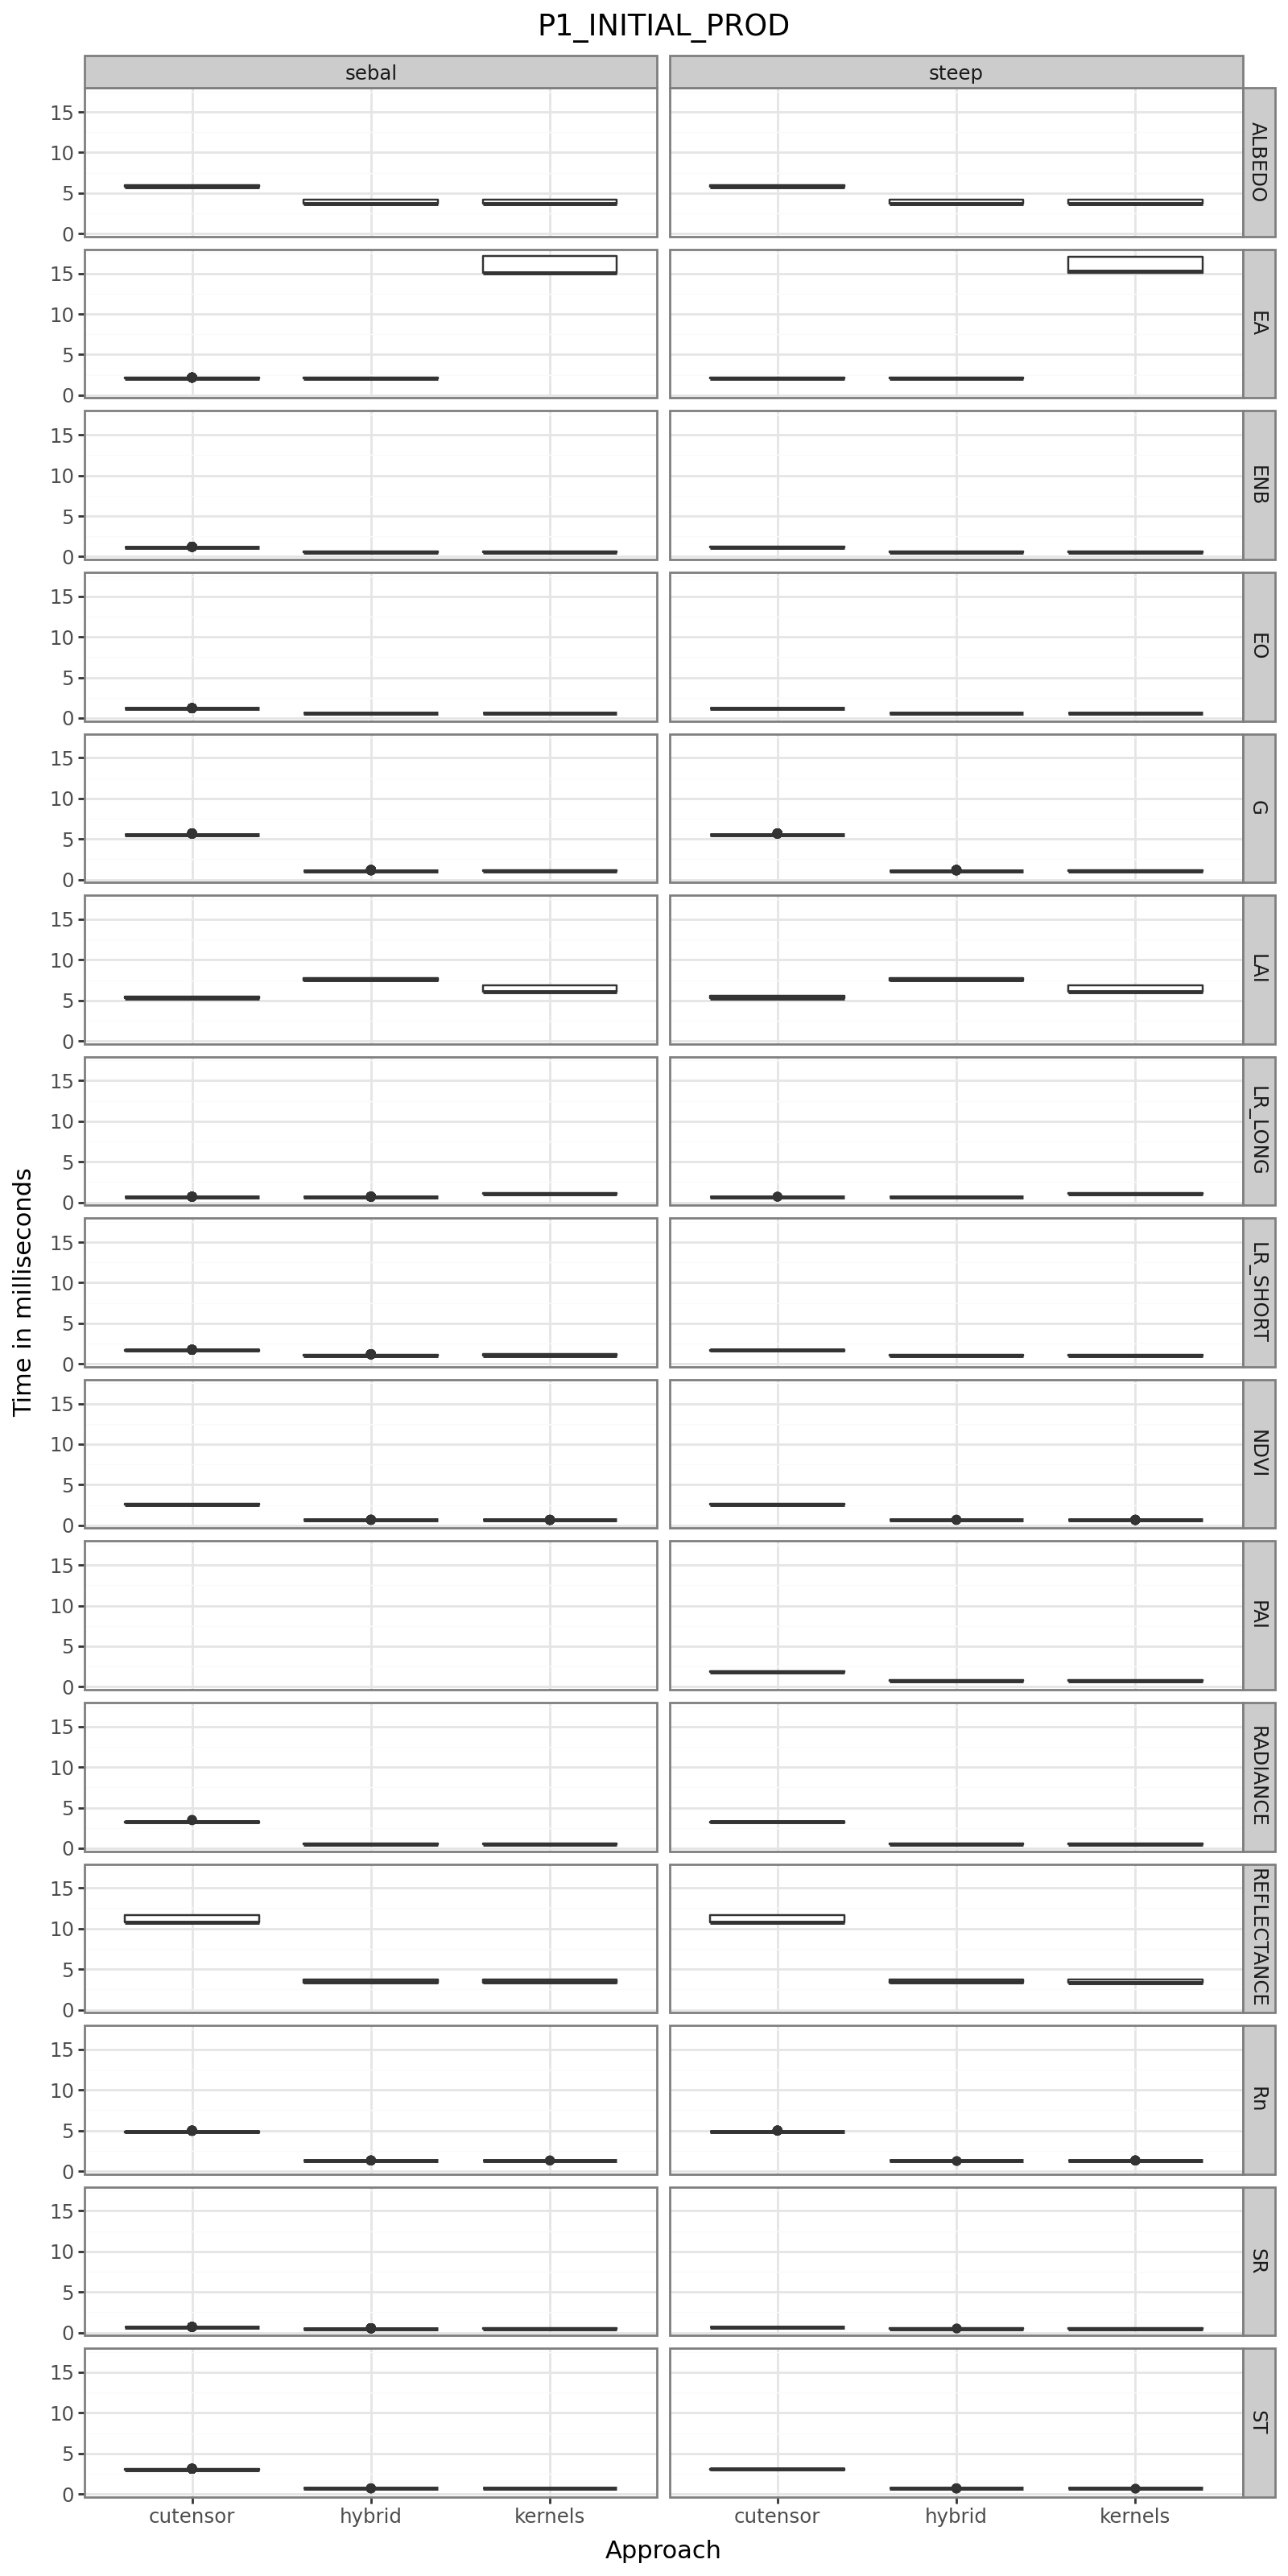

In [18]:
df = combined_dff[combined_dff['PHASE'].isin([
    'RADIANCE',
    'REFLECTANCE',
    'ALBEDO',
    'NDVI',
    'PAI',
    'LAI',
    'ENB',
    'EO',
    'EA',
    'ST',
    'SR',
    'LR_SHORT',
    'LR_LONG',
    'Rn',
    'G',
])]
df = df[df['LANG'] != 'serial']

options.figure_size = (8, 16)
(ggplot(df, aes(x='LANG', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE~METHOD")
 + labs(title=f"P1_INITIAL_PROD", y='Time in milliseconds', x='Approach')
 + theme_bw())

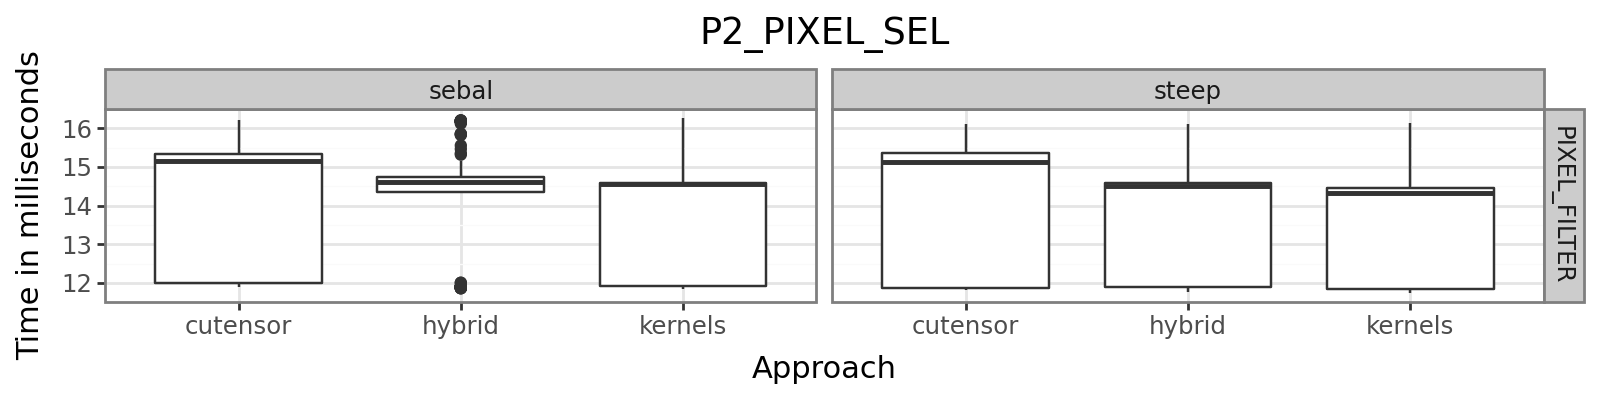

In [19]:
df = combined_dff[combined_dff['PHASE'].isin([
    'PIXEL_FILTER',
])]
df = df[df['LANG'] != 'serial']

options.figure_size = (8, 2)
(ggplot(df, aes(x='LANG', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE~METHOD")
 + labs(title=f"P2_PIXEL_SEL", y='Time in milliseconds', x='Approach')
 + theme_bw())

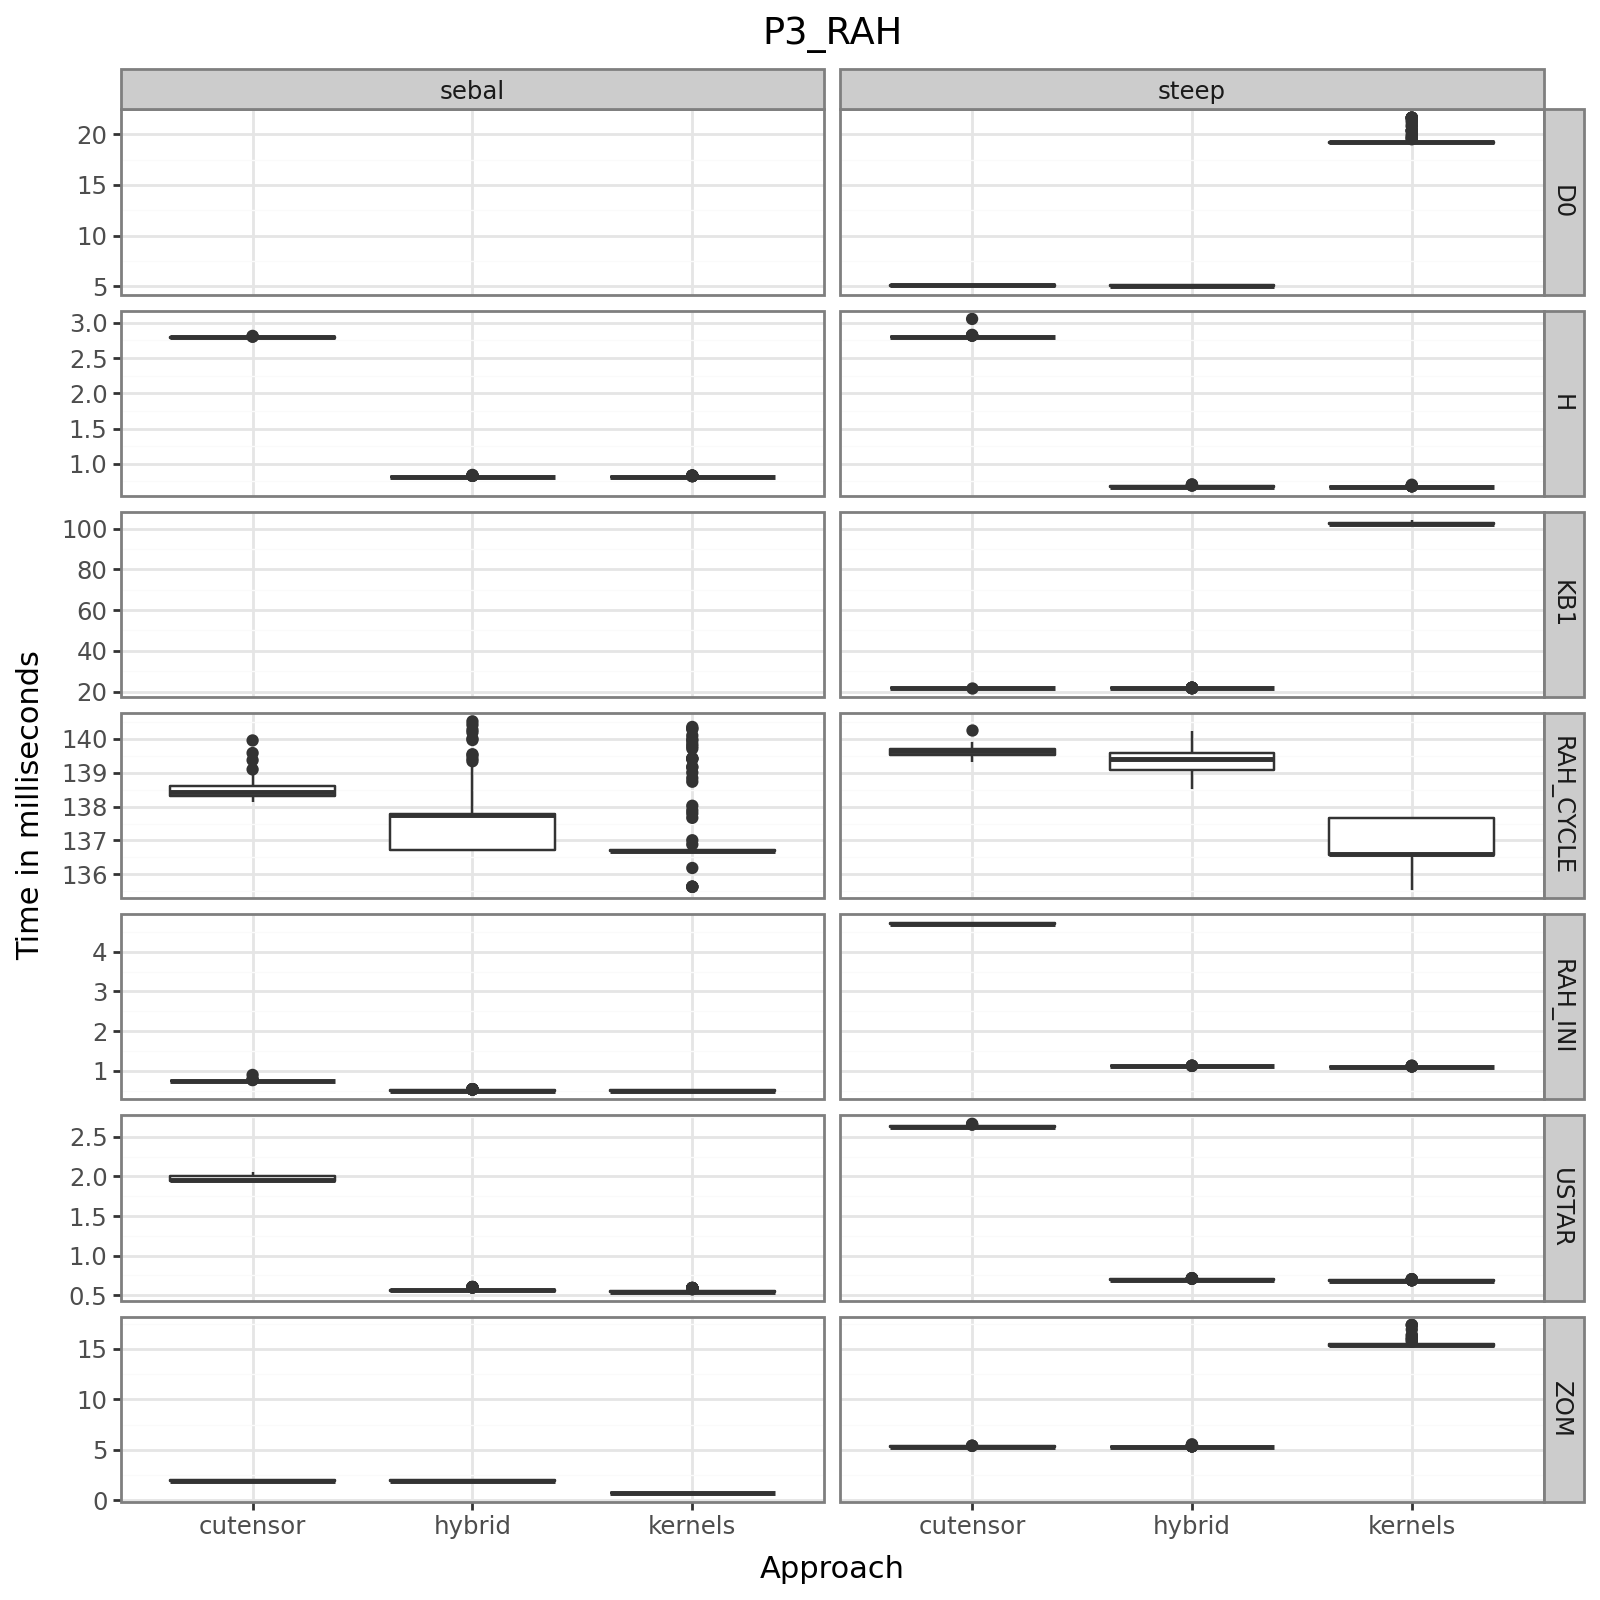

In [20]:
df = combined_dff[combined_dff['PHASE'].isin([
    'D0',
    'ZOM',
    'USTAR',
    'KB1',
    'RAH_INI',
    'RAH_CYCLE',
    'H',
])]
df = df[df['LANG'] != 'serial']

options.figure_size = (8, 8)
(ggplot(df, aes(x='LANG', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE~METHOD", scales='free')
 + labs(title=f"P3_RAH", y='Time in milliseconds', x='Approach')
 + theme_bw())

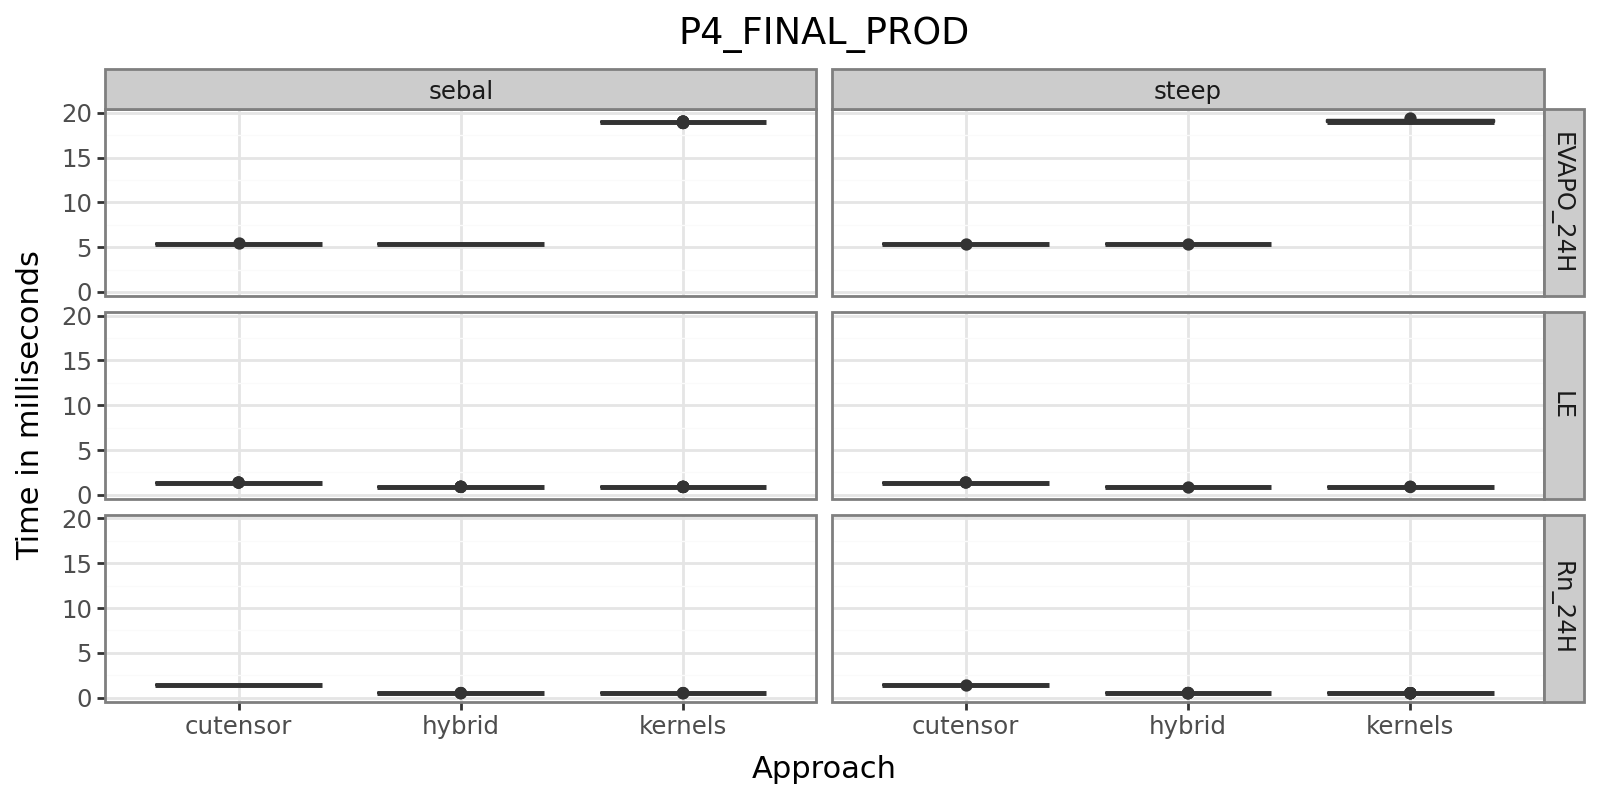

In [21]:
df = combined_dff[combined_dff['PHASE'].isin([
    'LE',
    'Rn_24H',
    'EVAPO_24H',
])]
df = df[df['LANG'] != 'serial']

options.figure_size = (8, 4)
(ggplot(df, aes(x='LANG', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE~METHOD")
 + labs(title=f"P4_FINAL_PROD", y='Time in milliseconds', x='Approach')
 + theme_bw())